In [35]:
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
import progressbar
import imageio
from glob import glob

In [2]:
data_path = "./data.nosync/climo_2005.h5"

In [3]:
h5f = h5py.File(data_path)
images = h5f["images"] # (1460,16,768,1152) numpy array
boxes = h5f["boxes"] # (1460,15,5) numpy array

In [10]:
DAY = 400

In [8]:
np.save("./data.nosync/wind_extremewather_2005", images[:,9:12:,:,:])

In [11]:
channels = images[DAY,:,:,:]
my_box = boxes[DAY]

In [20]:
hurricanes = my_box[(my_box[:, -1] == 2) | (my_box[:, -1] == 1)]

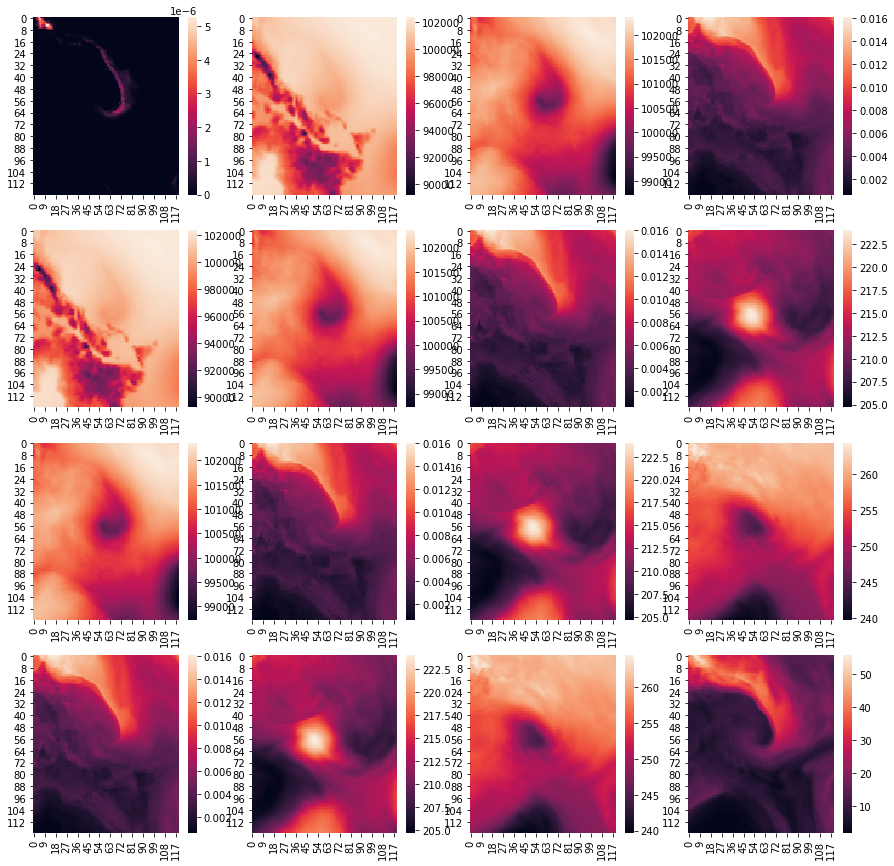

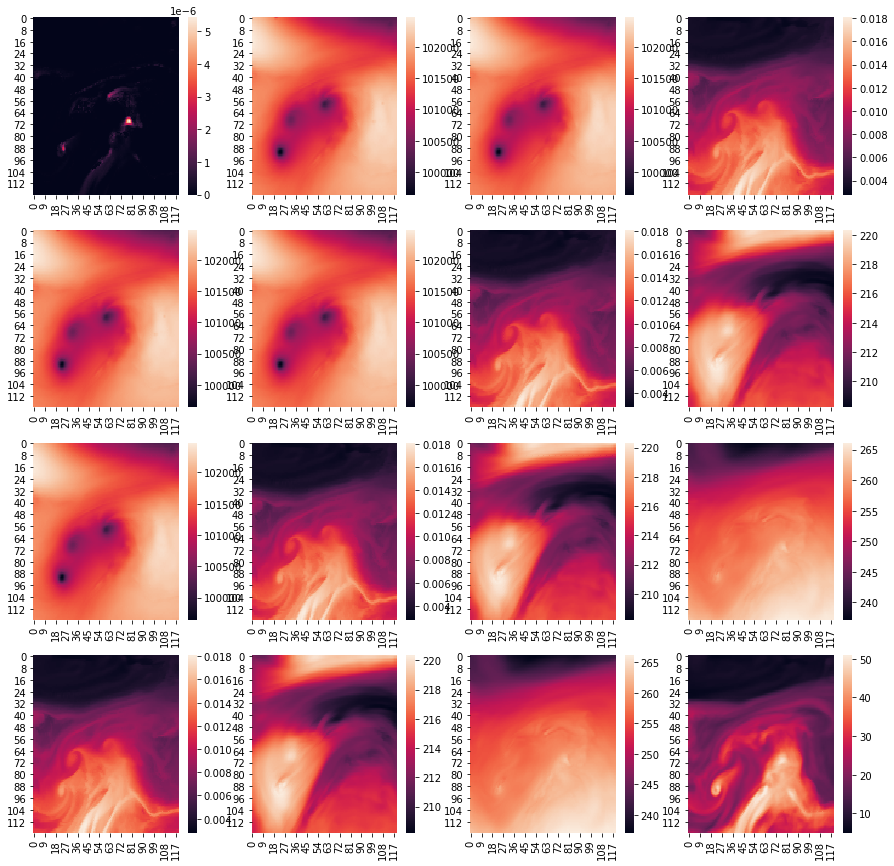

In [42]:
AROUND = 20
for cyclon in hurricanes:
    print('\n\n')
    fig, ax = plt.subplots(4, 4, )
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, row in enumerate(ax):
        for col, channel in zip(row, channels[i:i+4]):
                sns.heatmap(channel[cyclon[0] - AROUND:cyclon[2] + AROUND,
                                    cyclon[1] - AROUND:cyclon[3] + AROUND],
                            ax=col)
#         ax.invert_yaxis()
    plt.show()

**IDEA**: define a box around the cyclone. Use these images to train a CNN classifier for cyclons. This classifier will not be able to figure out where the cyclon is, but can identify if there is a cyclon in a given "small" image. This might be a first step for the project. Secondly, I could use OpenCV to train an image detection model, using the trained CNN classifier, to figure out where a cyclon might be.

In this scenario, I could also train on other classes, e.g. atmospheric river, but that depends for how long I can keep up.

# Create the train-test dataset

In [3]:
AROUND = 20

In [27]:
data_with_cyclon = [
    images[i, :, (cyclon[0] - AROUND):(cyclon[0] + 80 + AROUND),
           (cyclon[1] - AROUND):(cyclon[1] + 80 + AROUND)]
    for i, box in zip(range(10), boxes)
    for cyclon in box[(box[:, -1] == 2) | (box[:, -1] == 1)]
]

In [28]:
for el in data_with_cyclon:
    print(el.shape, end = '\t')

(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	(16, 120, 120)	

In [133]:
images.shape

(1456, 16, 768, 1152)

In [10]:
def give_random_internval(dim_shape = None):
    RANDOM_POS = np.random.randint(AROUND+10, dim_shape - AROUND-10)
    return slice(RANDOM_POS - AROUND, RANDOM_POS + 10 + AROUND)

In [11]:
# I use a generator to save memory
test = [
    1 for box in boxes for cyclon in box[(box[:, -1] == 2) | (box[:, -1] == 1)]
]
print("Number of positive training samples: %i" %len(test))

Number of positive training samples: 5897


In [12]:
from time import time
from sys import getsizeof
START = time()
test_list = [
    images[i, :, give_random_internval(images.shape[2]),
           give_random_internval(images.shape[3])] for i in range(60)
]
TIME = time() - START
print("Total computation time: %.2fs" % (TIME))
print("Memory usage: %.4fMB" % (float(getsizeof(test_list)) * 1e-6))
MIN = int((TIME / 60 * 6000) / 60)
SEC = (TIME / 60 * 6000) - MIN * 60
print("Estimated computation for 6000 elements: %imin %is" % (MIN, SEC))
print("Estimated memory usage: %.3fMB" %
      (float(getsizeof(test_list)) * 1e-6 / 60 * 6000))
# print("Memory usage: %.2fMB" %getsizeof(test_list)*1e-6)

Total computation time: 12.98s
Memory usage: 0.0006MB
Estimated computation for 6000 elements: 21min 38s
Estimated memory usage: 0.065MB


In [13]:
test_array = np.stack(test_list, axis = 0)

In [14]:
hf = h5py.File('./data.nosync/data_test.h5', 'w')

In [158]:
hf.create_dataset('test', data = test_array, compression = 'gzip')

<HDF5 dataset "test": shape (60, 16, 50, 50), type "<f4">

In [159]:
hf.close()

In [46]:
h5f_train = h5py.File('./data.nosync/train_pos.h5')

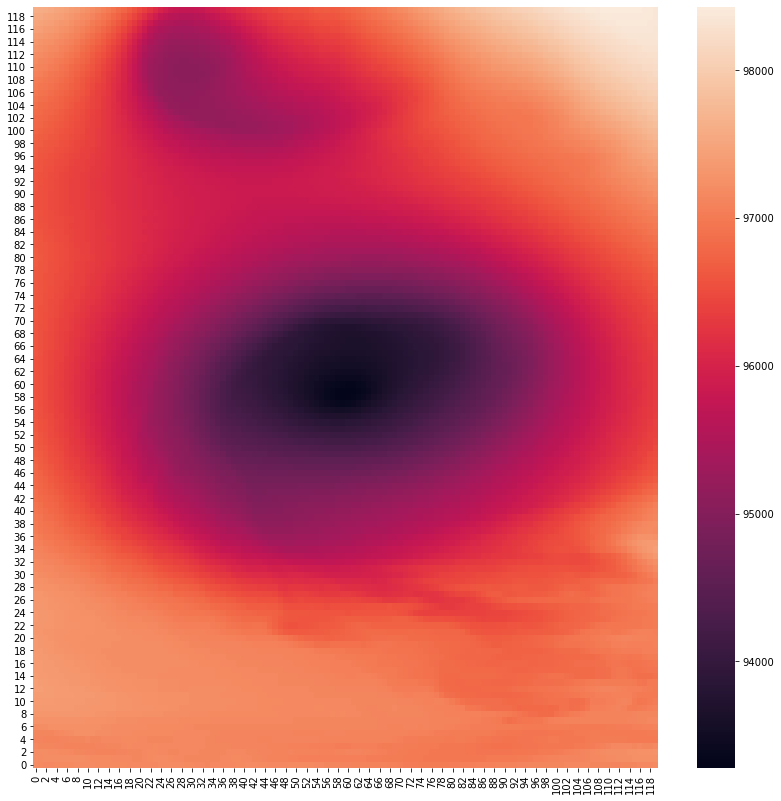

In [54]:
plt.figure(figsize = (14,14))
f = sns.heatmap(h5f_train['test'][3453, 2, :, :])
f.invert_yaxis()

# New Data Analysis

**PROBLEMA**: Nel tempo manca un giorno (4 misurazioni). Deduco che possano essere quelle dell'ultimo giorno dell'anno, ma non è detto

In [9]:
data_test = np.load("./data.nosync/wind_extremewather_2005.npy")

In [33]:
LAT = np.append(np.arange(-90, 90, 180/(data_test.shape[-2]-1)), 90)

In [34]:
LON = np.append(np.arange(0,360, 360/(data_test.shape[-1]-1)), 360)

In [91]:
TIME = np.arange(datetime(2005,1,1), datetime(2005,12,31), timedelta(hours = 6)).astype('str')

In [4]:
boxes

<HDF5 dataset "boxes": shape (1456, 15, 5), type "<i4">

In [5]:
hf = h5py.File('./data.nosync/georeferenced_wind_extremewearge_2005.h5', 'w')


In [7]:
hf['boxes'] = boxes[()]

In [53]:
hf = h5py.File('./data.nosync/georeferenced_wind_extremewearge_2005.h5', 'w')
hf.create_dataset('data', data=data_test, compression='gzip')
hf.create_dataset('latitude', data=LAT, compression='gzip')
hf.create_dataset('longitude', data=LON, compression='gzip')
hf.create_dataset('time', data=TIME, compression='gzip')
hf.close()

TypeError: No conversion path for dtype: dtype('<M8[us]')

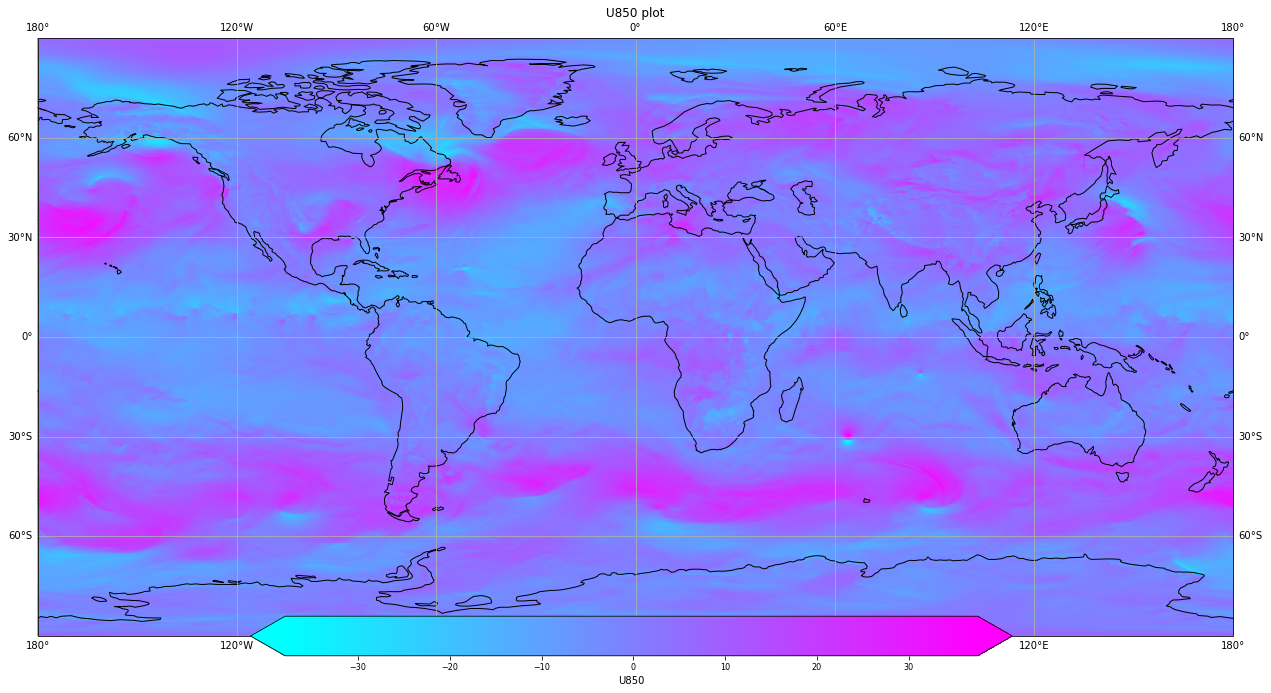

In [37]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(23,11))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot")
ax.set_global()
mm = ax.pcolormesh(LON, LAT, data_test[0,0,:,:], transform=ccrs.PlateCarree(),cmap=mpl.cm.cool )  

ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

**PROBLEMA**: i dati del modello sono giornalieri, mentre questi sono 4 valori per giorno. La cosa che si potrebbe sicuramente fare è una media sui 4 dati giornalieri (non penso che possa cambiare troppo). Questo però ridurrebbe sicuramente la dimensione del training set: avere dati extra, anche simili tra di loro, può essere utile.

# Test pre-processed data

In [3]:
data_path = './data.nosync/georeferenced_wind_extremewearge_2005.h5'
h5f = h5py.File(data_path)
# images = h5f["images"] # (1460,16,768,1152) numpy array
# boxes = h5f["boxes"] # (1460,15,5) numpy array

In [7]:
for el in h5f.keys():
    print(el, h5f[el].shape)

boxes (1456, 15, 5)
data (1456, 3, 768, 1152)
latitude (768,)
longitude (1152,)
time (1456,)


In [29]:
h5f['data'][j,0,:,:].min()

-44.43629

In [36]:
for j, tt in progressbar.progressbar(
        enumerate(h5f['time'][()].astype("<M8[us]"))):
    if j < 500:
        fig = plt.figure(figsize=(23 / 2, 11 / 2))  # x,y(inches)

        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_title("U850 plot, time" + str(tt))
        ax.set_global()
        mm = ax.pcolormesh(h5f['longitude'],
                           h5f['latitude'],
                           h5f['data'][j, 0, :, :],
                           transform=ccrs.PlateCarree(),
                           cmap=mpl.cm.coolwarm,
                           vmin=-50,
                           vmax=50)

        ax.coastlines()
        ax.gridlines(draw_labels=True)

        #- add colorbar
        cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                                0.05])  #[left, bottom, width, height]
        cbar = fig.colorbar(mm,
                            cax=cbar_ax,
                            extend='both',
                            orientation='horizontal')
        cbar.set_label('U850')
        cbar.ax.tick_params(labelsize=8)
        plt.savefig('./images/U850_' + str(tt) + ".jpg")
        plt.close()
    else:
        break
        #     plt.show()

images = [imageio.imread(filename) for filename in glob("./images/*.jpg")]
# images = []
# for filename in filenames:
#     images.append(imageio.imread(filename))
imageio.mimsave('./images/wind_movie.gif', images)

/ |                     #                           | 500 Elapsed Time: 0:40:38

In [39]:
images = [imageio.imread(filename) for filename in sorted(glob("./images/*.jpg"))]
# images = []
# for filename in filenames:
#     images.append(imageio.imread(filename))
imageio.mimsave('./images/wind_movie.gif', images)